# A Bayesian regularized artificial neural network for stock market forecasting

## Setup

In [1]:
BACKUP_PATH = "./backup/"

In [2]:
from lib.dataset import Data

from lib.model.optimize import run_one_epoch 
from lib.model.utils import reset_all_weights, generate_bnn_summary
from lib.model.loss import WeightedLoss, mape_loss
from lib.model.plot import training_plot_summary

from lib.backtest import (
    create_backtest_dataset, 
    backtest_plot, 
    generate_price_distribution, 
    plot_predicted_distribution, 
)

In [3]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.axes import Axes

import rich

In [4]:
import torch
import torch.nn as nn
import torchbnn 
from torchsummary import summary

# from langevin_sampling.SGLD import SGLD
# https://github.com/alisiahkoohi/Langevin-dynamics/blob/master/langevin_sampling/SGLD.py

In [5]:
from pickle import load, dump 

## Financial Data

In [51]:
ticker = "GS"

start_date = "2010-01-04"
end_date = "2012-12-31"
window_size = 32

train_prop = .8
ema_n_days = [5, 10] 
d_period = 3

data = Data(ticker, start_date, end_date, window_size, train_prop, ema_n_days, d_period)

[*********************100%***********************]  1 of 1 completed


c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [42]:
print(data)

Data(ticker='GS', start_date='2010-01-04', end_date='2012-12-31', batch_size=32, train_prop=0.8, ema_n_days=[5, 10], d_period=3, target_name='Close+1')


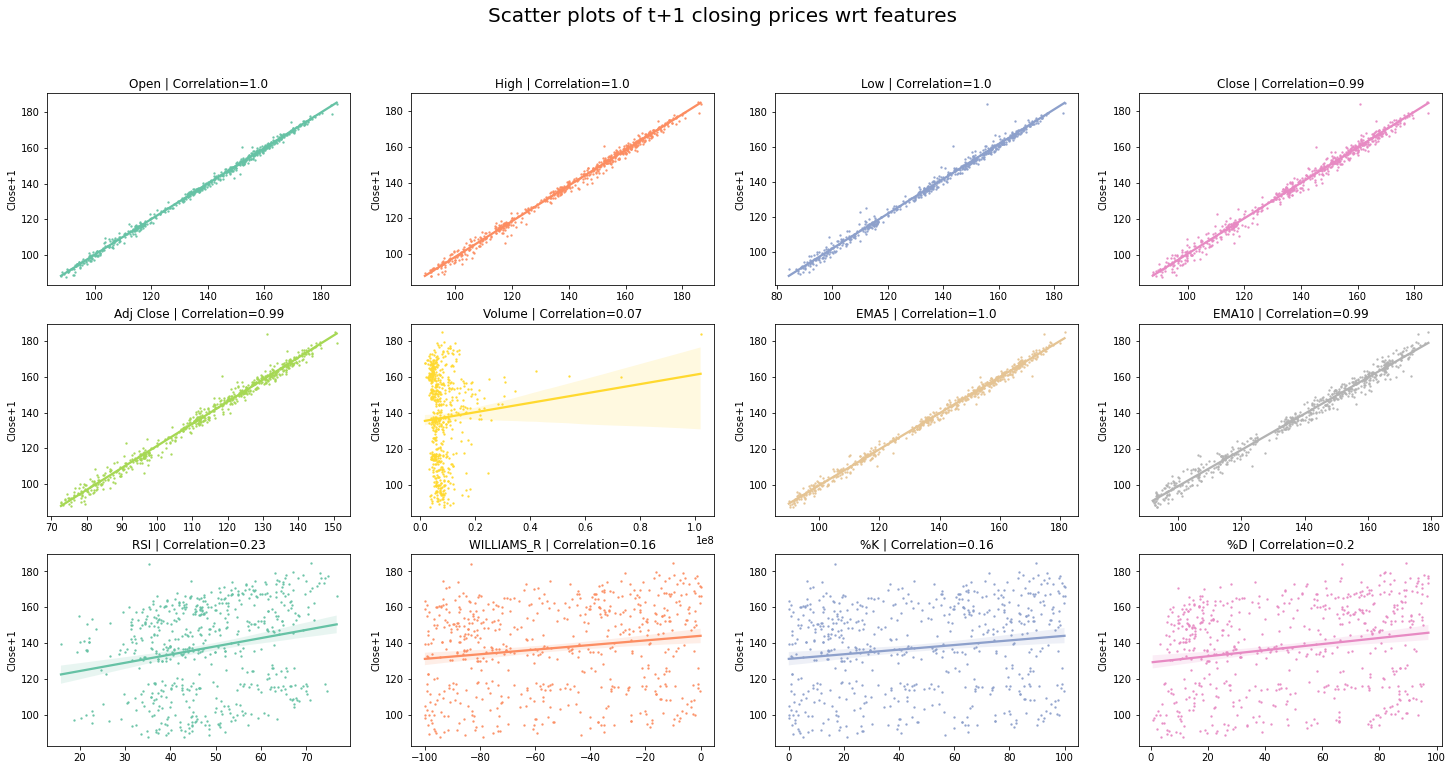

In [43]:
id_vars = data._df_train.columns.drop(labels="Close+1").tolist()
cor_mat = data._df_train.corr()["Close+1"]

ncols = 4
if len(id_vars) % ncols == 0: 
    nrows = len(id_vars) // ncols
else: 
    nrows = len(id_vars) // ncols + 1

colors = sns.color_palette("Set2", n_colors=len(id_vars)) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))
fig.suptitle("Scatter plots of t+1 closing prices wrt features", size=20)

def make_regplot(var_name: str, ax: Axes, color: str): 
    sns.regplot(
        data=data._df_train, 
        x=var, 
        y="Close+1", 
        scatter_kws={"s": 2}, 
        color=color, 
        ax=ax)
    ax.set_title(f"{var} | Correlation={round(cor_mat[var], 2)}")
    ax.set_xlabel("")

for var, ax, c in zip(id_vars, axes.flatten(), colors):
    make_regplot(var, ax, c)

## Training & validation

### Frequentist MLP

In [46]:
input_size = 9 
hidden_size = 5
output_size = 1

fnn = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size)
)

print(fnn)

Sequential(
  (0): Linear(in_features=9, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


In [47]:
criterion = WeightedLoss(alpha=.5, beta=.5, optimize=True)

lr = .01
params = list(fnn.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [48]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 100
mape_prev = 0
tol = 1e-4

In [49]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(fnn, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [41/100]: 100%|██████████| 19/19 [00:00<00:00, 93.53it/s, train_loss=0.251, val_loss=0.233, val_mape=1.11]

MAPE difference=7.873773574829102e-05


In [52]:
# save model and criterion as .pt files

asset = "gs"
model_file_name = asset+"-fnn.pt"
loss_file_name = asset+"-weighted_loss_fnn.pt"

# torch.save(fnn, BACKUP_PATH+"models/"+model_file_name)
# torch.save(criterion, BACKUP_PATH+"loss/"+loss_file_name)

bnn = torch.load(BACKUP_PATH+"models/"+model_file_name)
loss = torch.load(BACKUP_PATH+"loss/"+loss_file_name)

In [53]:
# save results as pickle file
results_file_name = asset+"results_fnn.pkl"

# with open(file=BACKUP_PATH+"training/"+results_file_name, mode="wb") as f: 
#     dump(results, f) 

# load results from pickle file
with open(file=BACKUP_PATH+"training/"+results_file_name, mode="rb") as f: 
    results = load(f)

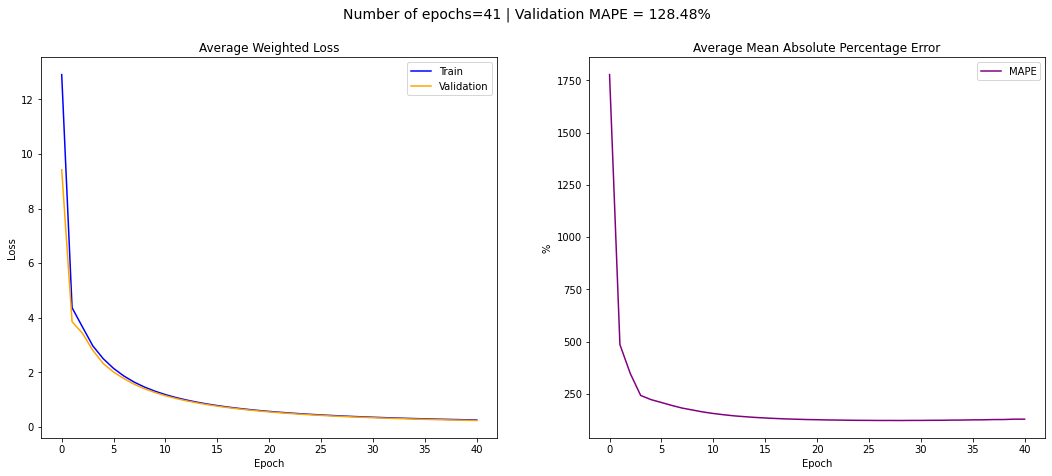

In [54]:
training_plot_summary(results); 

In [55]:
summary(model=fnn, input_size=(1, 9), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 1, 5]              50
              Tanh-2                 [32, 1, 5]               0
            Linear-3                 [32, 1, 1]               6
Total params: 56
Trainable params: 56
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Bayesian MLP

#### Optimization without KL divergence

In [56]:
input_size = 9 
hidden_size = 5
output_size = 1

bnn = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

print(bnn)

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=9, out_features=5, bias=True)
  (1): Tanh()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=1, bias=True)
)


In [57]:
summary_bnn = generate_bnn_summary(bnn)
rich.print(summary_bnn)

                                  Bayesian NN architecture                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Distrbution params        ┃ Tensors                  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([5, 9]) |     │ 100     │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([5, 9]) |     │         │
│ in_features=9,           │ bias_mu | bias_log_sigma  │ torch.Size([5]) |        │         │
│ out_features=5,          │                           │ torch.Size([5])          │         │
│ bias=True)               │                           │                          │         │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ Tanh()                   │                           │                          │ 0.0     │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([1, 5]) |     │ 12      │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([1, 5]) |     │         │
│ in_features=5,           │ bias_mu | bias_log_sigma  │ torch.Size([1]) |        │         │
│ out_features=1,          │                           │ torch.Size([1])          │         │
│ bias=True)               │                           │                          │         │
└──────────────────────────┴───────────────────────────┴──────────────────────────┴─────────┘

In [58]:
criterion = WeightedLoss(alpha=.5, beta=.5, optimize=True)

In [59]:
lr = .01
params = list(bnn.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [60]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 200
mape_prev = 0
tol = 1e-4

In [61]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(bnn, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [200/200]: 100%|██████████| 19/19 [00:00<00:00, 64.82it/s, train_loss=1.46, val_loss=1.47, val_mape=2.52] 


In [62]:
# save model and criterion as .pt files
asset = "gs"

model_file_name = asset+"-bnn.pt"
loss_file_name = asset+"-weighted_loss_bnn.pt"

torch.save(bnn, BACKUP_PATH+"models/"+model_file_name)
torch.save(criterion, BACKUP_PATH+"loss/"+loss_file_name)

bnn = torch.load(BACKUP_PATH+"models/"+model_file_name)
loss = torch.load(BACKUP_PATH+"loss/"+loss_file_name)

In [63]:
# save results as pickle file
results_file_name = asset+"results_bnn.pkl"

with open(file=BACKUP_PATH+"training/"+results_file_name, mode="wb") as f: 
    dump(results, f) 

# load results from pickle file
with open(file=BACKUP_PATH+"training/"+results_file_name, mode="rb") as f: 
    results = load(f)

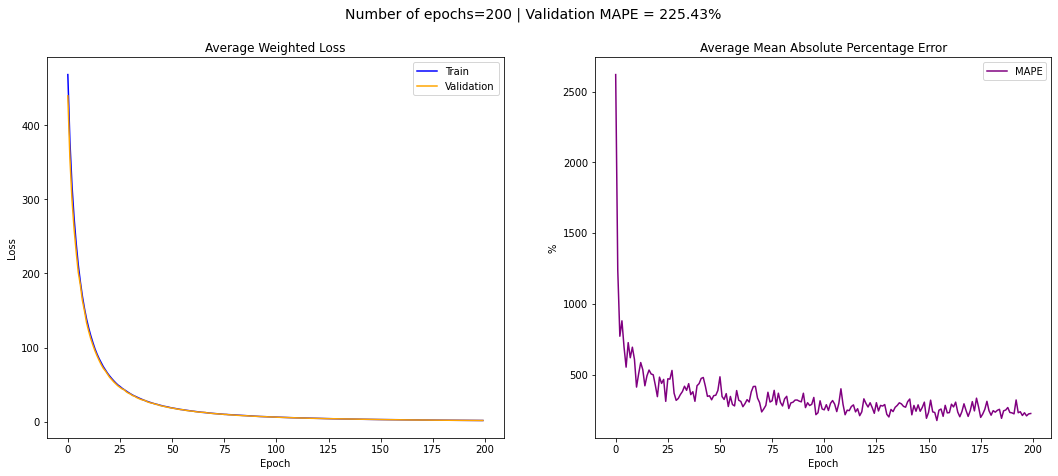

In [64]:
training_plot_summary(results); 

#### Optimization with KL divergence

In [65]:
input_size = 9 
hidden_size = 5
output_size = 1

bnn_kl = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

In [66]:
criterion = WeightedLoss(alpha=.5, beta=.5, kl_weight=.1, optimize=True, optimize_kl=False)

lr = .01
params = list(bnn_kl.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)

In [67]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 200
mape_prev = 0
tol = 1e-4

In [68]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(bnn_kl, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [200/200]: 100%|██████████| 19/19 [00:00<00:00, 60.77it/s, train_loss=1.78, val_loss=1.47, val_mape=2.29]


In [69]:
asset = "gs"

model_file_name = asset+"-bnn_kl.pt"
loss_file_name = asset+"-weighted_loss_kl.pt"

# torch.save(bnn_kl, BACKUP_PATH+"models/"+model_file_name)
# torch.save(criterion, BACKUP_PATH+"loss/"+loss_file_name)

bnn_kl = torch.load(BACKUP_PATH+"models/"+model_file_name)
criterion = torch.load(BACKUP_PATH+"loss/"+loss_file_name)

In [70]:
# save results as pickle file
results_file_name = asset+"-results_bnn_kl.pkl"

# with open(file=BACKUP_PATH+"training/"+results_file_name, mode="wb") as f: 
#     dump(results, f) 

# load results from pickle file
with open(file=BACKUP_PATH+"training/"+results_file_name, mode="rb") as f: 
    results = load(f)

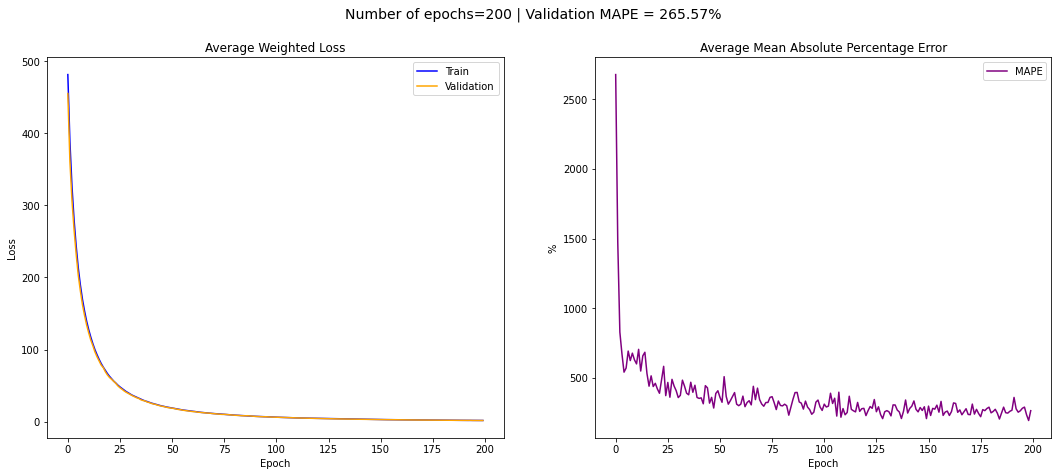

In [71]:
training_plot_summary(results); 

## Backtest

In [72]:
asset = "gs"

files = [f"{asset}-{m}" for m in ("fnn", "bnn", "bnn_kl")]

models = {
    f: torch.load(BACKUP_PATH+"models/"+f+".pt")
    for f in files
}

### Frequentist MLP

**Training set**

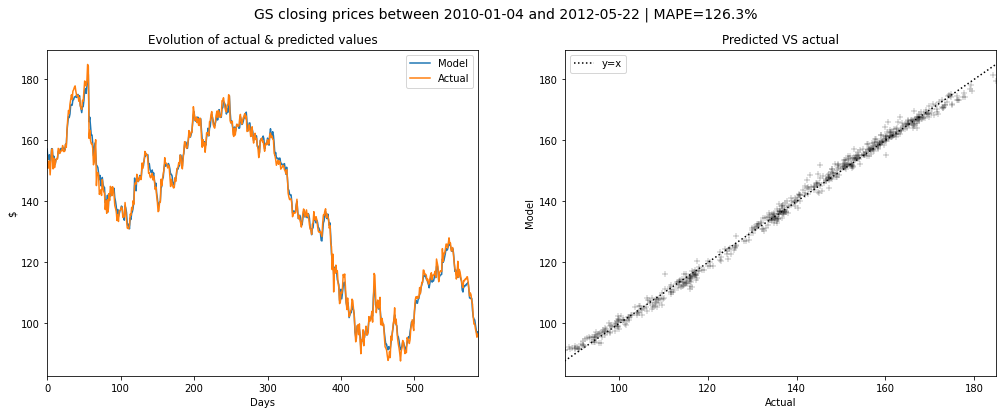

In [75]:
df_backtest, mape = create_backtest_dataset(data=data, model=models[asset+"-fnn"], training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set**

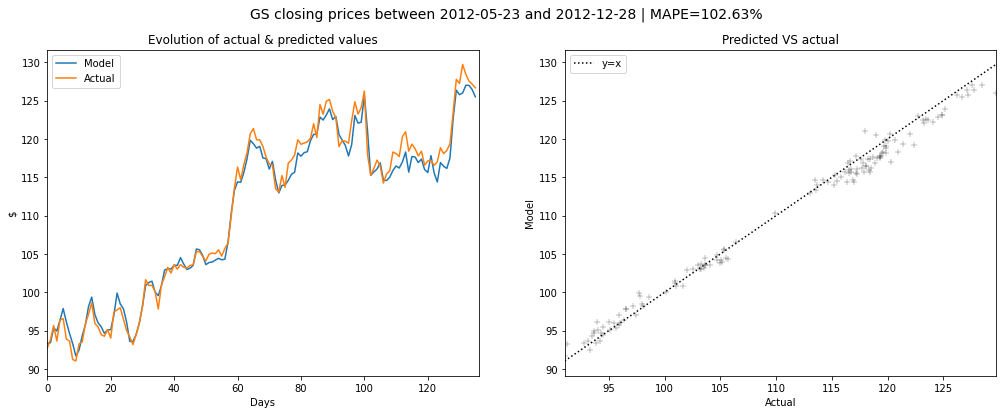

In [76]:
df_backtest, mape = create_backtest_dataset(data=data, model=models[asset+"-fnn"], training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

### Bayesian MLP

#### Without KL divergence

**Training set**

In [77]:
# generate 100 predictions per day in the test set 
preds_bnn_tr = generate_price_distribution(data, models[asset+"-bnn"], training=True)

# take the daily average 
avg_preds_bnn_kl_tr = preds_bnn_tr.T.mean(axis=1).values.reshape(-1, 1)

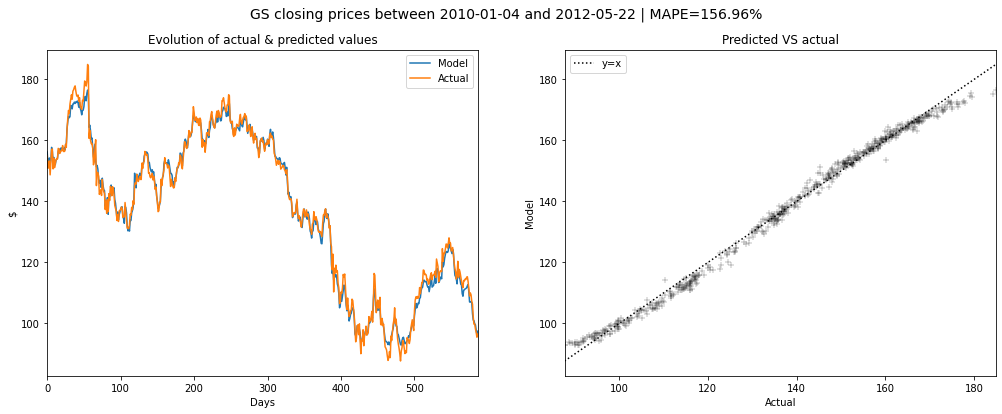

In [78]:
df_backtest, mape = create_backtest_dataset(data, preds=avg_preds_bnn_kl_tr, training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set** 

In [79]:
# generate 100 predictions per day in the test set 
preds_bnn_te = generate_price_distribution(data, models[asset+"-bnn"], training=False)

# take the daily average 
avg_preds_bnn_te = preds_bnn_te.T.mean(axis=1).values.reshape(-1, 1)

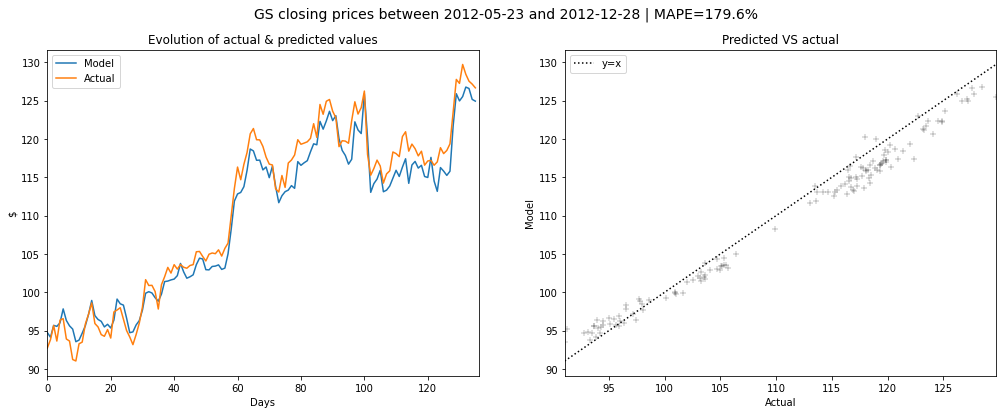

In [80]:
df_backtest, mape = create_backtest_dataset(data=data, preds=avg_preds_bnn_te, training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

#### With KL divergence

**Training set**

In [81]:
# generate 100 predictions per day in the test set 
preds_bnn_kl_tr = generate_price_distribution(data, models[asset+"-bnn_kl"], training=True)

# take the daily average 
avg_preds_bnn_kl_tr = preds_bnn_kl_tr.T.mean(axis=1).values.reshape(-1, 1)

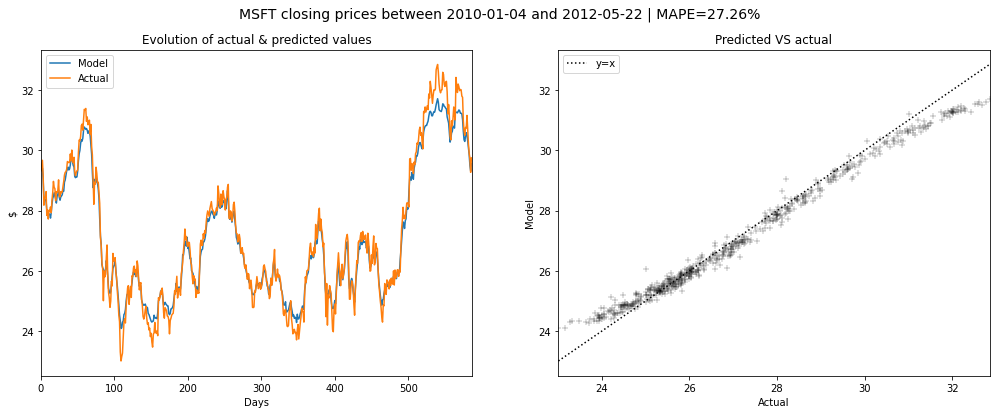

In [ ]:
df_backtest, mape = create_backtest_dataset(data, preds=avg_preds_bnn_kl_tr, training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set**

In [ ]:
# generate 100 predictions per day in the test set 
preds_bnn_kl_te = generate_price_distribution(data, models[asset+"-bnn_kl"], training=False)

# take the daily average 
avg_preds_bnn_kl_te = preds_bnn_kl_te.T.mean(axis=1).values.reshape(-1, 1)

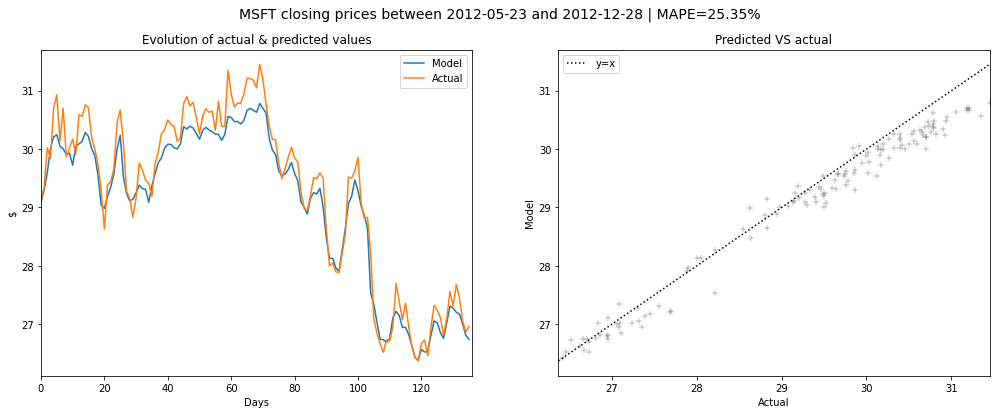

In [ ]:
df_backtest, mape = create_backtest_dataset(data=data, preds=avg_preds_bnn_kl_te, training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

### Uncertainty measurement through simulations

In [38]:
date = "2012-06-19"

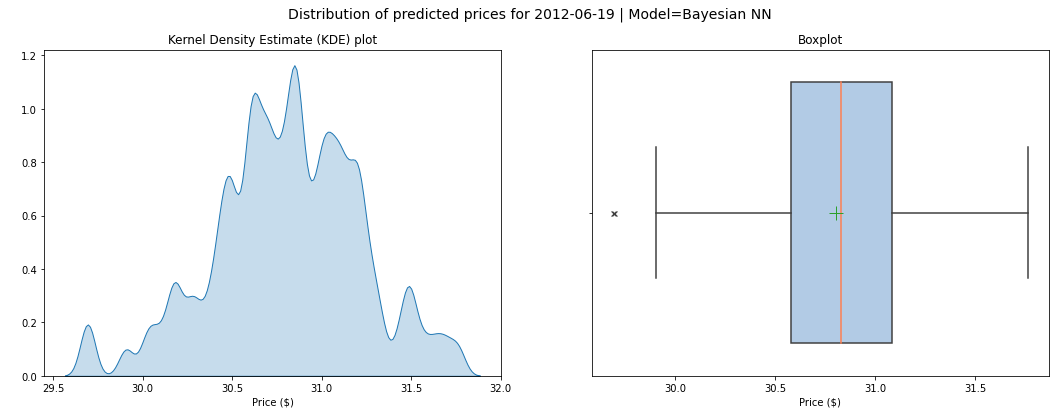

In [39]:
plot_predicted_distribution(preds_bnn_te, date=date, model_name="Bayesian NN")

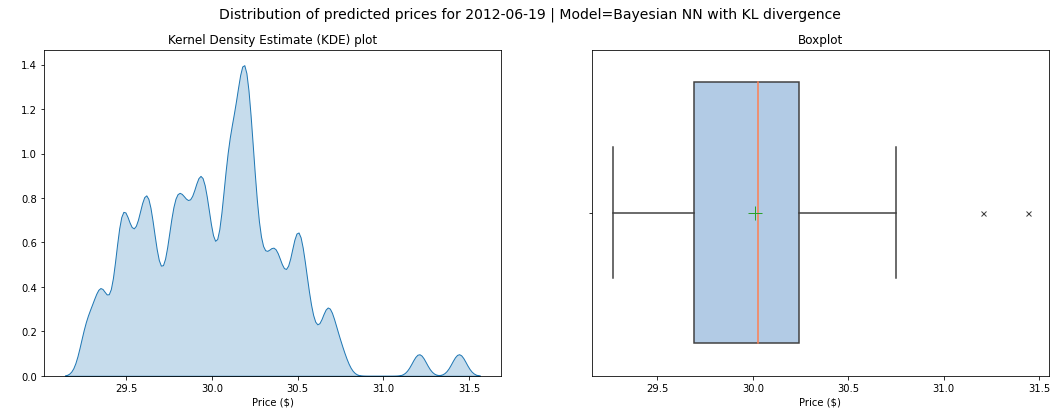

In [40]:
plot_predicted_distribution(preds_bnn_kl_te, date=date, model_name="Bayesian NN with KL divergence")